<a href="https://colab.research.google.com/github/MaanasSM/Deep-Learning-Mini-Projects/blob/main/Object_Detection_lab6_19_2_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install kaggle -q
!pip install torch torchvision -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# ======== STEP 1: Authenticate with Kaggle =========
print("No need to upload kaggle.json. We will set API credentials directly in Colab.")

# Set Kaggle API credentials (Replace with your credentials)
os.environ["KAGGLE_USERNAME"] = "bluelemons"  # Replace with your Kaggle username
os.environ["KAGGLE_KEY"] = "9ba83544e89a37efa719b1785b348ba2"  # Replace with your Kaggle API key

# Download the dataset (Ships in Satellite Imagery)
KAGGLE_DATASET = "rhammell/ships-in-satellite-imagery"
!mkdir -p /content/kaggle_dataset
!kaggle datasets download -d {KAGGLE_DATASET} --unzip -p /content/kaggle_dataset

# Verify dataset files
dataset_path = "/content/kaggle_dataset"
print("Files in dataset:", os.listdir(dataset_path))


No need to upload kaggle.json. We will set API credentials directly in Colab.
Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
 99% 183M/185M [00:09<00:00, 24.5MB/s]
100% 185M/185M [00:09<00:00, 20.6MB/s]
Files in dataset: ['scenes', 'shipsnet.json', 'shipsnet']


In [ ]:
# ======== STEP 2: Preprocess Dataset =========
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import os
print("Files in dataset folder:", os.listdir(dataset_path))


Files in dataset folder: ['scenes', 'shipsnet.json', 'shipsnet']


In [ ]:
# # Custom dataset loader (Assuming images are in 'shipsnet.json' format, change according to dataset structure)
# class CustomDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.image_files[idx])
#         image = Image.open(img_name).convert("RGB")

#         if self.transform:
#             image = self.transform(image)

#         # Modify based on your dataset's label extraction logic
#         label = int(self.image_files[idx].split('_')[0])  # Example: get label from filename

#         return image, label

# # Load the dataset
# train_dataset = CustomDataset(root_dir=dataset_path, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class ShipsDataset(Dataset):
    def __init__(self, json_path, transform=None):
        with open(json_path, "r") as f:
            data = json.load(f)  # Load JSON
        self.images = np.array(data["data"], dtype=np.uint8)  # Image pixel data
        self.labels = np.array(data["labels"], dtype=np.int64)  # Labels (0 or 1)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(3, 80, 80).transpose(1, 2, 0)  # Reshape to (80,80,3)
        image = Image.fromarray(image)  # Convert NumPy array to PIL image

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Correct dataset path
json_file_path = os.path.join(dataset_path, "shipsnet.json")

# Load dataset correctly
train_dataset = ShipsDataset(json_file_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Print dataset size
print("Dataset size:", len(train_dataset))


Dataset size: 4000


In [ ]:
# ======== STEP 3: Load Pretrained InceptionV3 Model =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.inception_v3(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Change this based on the number of classes in your dataset (e.g., 2 classes)
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 71.5MB/s]


In [ ]:
# ======== STEP 4: Define Loss & Optimizer =========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# ======== STEP 5: Train the Model =========
num_epochs = 5  # Adjust based on dataset size
print("Training Started...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Complete!")

Training Started...
Epoch [1/5], Loss: 0.2393
Epoch [2/5], Loss: 0.1420
Epoch [3/5], Loss: 0.0909
Epoch [4/5], Loss: 0.0785
Epoch [5/5], Loss: 0.0589
Training Complete!


In [ ]:
# ======== STEP 6: Save the Fine-Tuned Model =========
torch.save(model.state_dict(), "fine_tuned_inceptionv3.pth")
print("Model saved as fine_tuned_inceptionv3.pth")

Model saved as fine_tuned_inceptionv3.pth


In [ ]:
import os
import torch
import random
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import json

In [ ]:
import os

dataset_path = "/content/kaggle_dataset"
print("Files in dataset:", os.listdir(dataset_path))


Files in dataset: ['scenes', 'shipsnet.json', 'shipsnet']


In [ ]:
# ============ STEP 1: Load Dataset from JSON ============
json_file_path = "/content/kaggle_dataset/shipsnet.json"

# Load JSON file
with open(json_file_path, "r") as f:
    data = json.load(f)

images = np.array(data["data"], dtype=np.uint8)  # Image data (flattened)
labels = np.array(data["labels"], dtype=np.int64)  # Labels (0 = No Ship, 1 = Ship)

# Print dataset stats
print(f"✅ Loaded {len(images)} images from shipsnet.json")
print(f"✅ Image shape before reshape: {images.shape}")

✅ Loaded 4000 images from shipsnet.json
✅ Image shape before reshape: (4000, 19200)


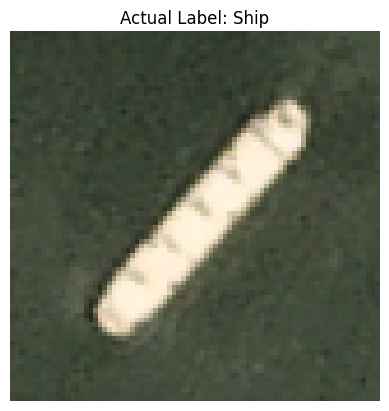

In [ ]:
# ============ STEP 2: Select a Random Image ============
sample_idx = random.randint(0, len(images) - 1)  # Pick a random index
image_array = images[sample_idx].reshape(3, 80, 80).transpose(1, 2, 0)  # Reshape to (80x80x3)
label = labels[sample_idx]  # True label

# Convert to PIL image
image = Image.fromarray(image_array)

# Display image
plt.imshow(image)
plt.title(f"Actual Label: {'Ship' if label == 1 else 'No Ship'}")
plt.axis("off")
plt.show()

In [ ]:
# ============ STEP 3: Preprocess Image for Model ============
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to match InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension & send to GPU


In [ ]:
# ============ STEP 4: Run Model Inference ============
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1).item()  # Get predicted label


In [ ]:
# ============ STEP 5: Print Prediction ============
print(f"✅ Model Prediction: {'Ship' if prediction == 1 else 'No Ship'}")

✅ Model Prediction: Ship


In [ ]:
!wget "https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data" -O dataset.zip
!unzip dataset.zip -d /content/dataset

--2025-03-05 10:55:29--  https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset.zip’

dataset.zip             [ <=>                ]  13.32K  --.-KB/s    in 0.05s   

2025-03-05 10:55:30 (250 KB/s) - ‘dataset.zip’ saved [13642]

Archive:  dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dataset.zip or
        dataset.zip.zip, and cannot find dataset.zip.ZIP, period.


In [ ]:
!kaggle datasets download -d rhammell/ships-in-satellite-imagery --unzip -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
 99% 184M/185M [00:09<00:00, 23.3MB/s]
100% 185M/185M [00:09<00:00, 20.8MB/s]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 63, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1586, in dataset_download_cli
    self.dataset_download_files(dataset,
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1520, in dataset_download_files
    z.extractall(effective_path)
  File "/usr/lib/python3.11/zipfile.py", line 1702, in extractall
    self._extract_member(zipinfo, path, pwd)
  File "/usr/lib/python3.11/zipfile.py", line 1757, in _extract_member
    shutil.copyfileobj(source, target)
  File "/usr/lib/python3.11/shutil.py", line 197, in copyfileobj
^C
